# Time Series Forecasting of Walmart Sales Using ARIMA & SARIMA

About the dataset: This is the historical data that covers sales from 2010-02-05 to 2012-11-01.

## Importing the dataset

In [21]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action="ignore", category=UserWarning)

In [22]:
df=pd.read_csv('walmart.csv')

In [23]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [24]:
df.tail()

,Store,Dept,Date,Weekly_Sales,IsHoliday
421565,45,98,2012-09-28,508.37,False
421566,45,98,2012-10-05,628.10,False
421567,45,98,2012-10-12,1061.02,False
421568,45,98,2012-10-19,760.01,False
421569,45,98,2012-10-26,1076.80,False


### Data cleaning and pre processing

In [25]:
df.isnull().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64

In [26]:
df=df[['Date', 'Weekly_Sales']]
df.head()

,Date,Weekly_Sales
0,2010-02-05,24924.50
1,2010-02-12,46039.49
2,2010-02-19,41595.55
3,2010-02-26,19403.54
4,2010-03-05,21827.90


In [27]:
df["Date"] = pd.to_datetime(df["Date"]) 
df["Date"]=df["Date"].dt.strftime("%Y-%m")  #in order to group sales wrt month
df

,Date,Weekly_Sales
0,2010-02,24924.50
1,2010-02,46039.49
2,2010-02,41595.55
3,2010-02,19403.54
4,2010-03,21827.90
...,...,...
421565,2012-09,508.37
421566,2012-10,628.10
421567,2012-10,1061.02
421568,2012-10,760.01


In [30]:
dfm = df.groupby("Date")["Weekly_Sales"].sum().reset_index() #grouping w.r.t month
dfm.head()

,Date,Weekly_Sales
0,2010-02,1.903330e+08
1,2010-03,1.819198e+08
2,2010-04,2.314124e+08
3,2010-05,1.867109e+08
4,2010-06,1.922462e+08


In [31]:
dfm.columns=["Month", "Sales"]
dfm.head()

,Month,Sales
0,2010-02,1.903330e+08
1,2010-03,1.819198e+08
2,2010-04,2.314124e+08
3,2010-05,1.867109e+08
4,2010-06,1.922462e+08


In [32]:
dfm.set_index('Month',inplace=True)
dfm.head()

,Sales
Month,
2010-02,1.903330e+08
2010-03,1.819198e+08
2010-04,2.314124e+08
2010-05,1.867109e+08
2010-06,1.922462e+08


In [33]:
dfm.describe()

,Sales
count,3.300000e+01
mean,2.041582e+08
std,3.047330e+07
min,1.637040e+08
25%,1.843617e+08
50%,1.897734e+08
75%,2.265265e+08
max,2.887605e+08


## Data Visualization & Analysis

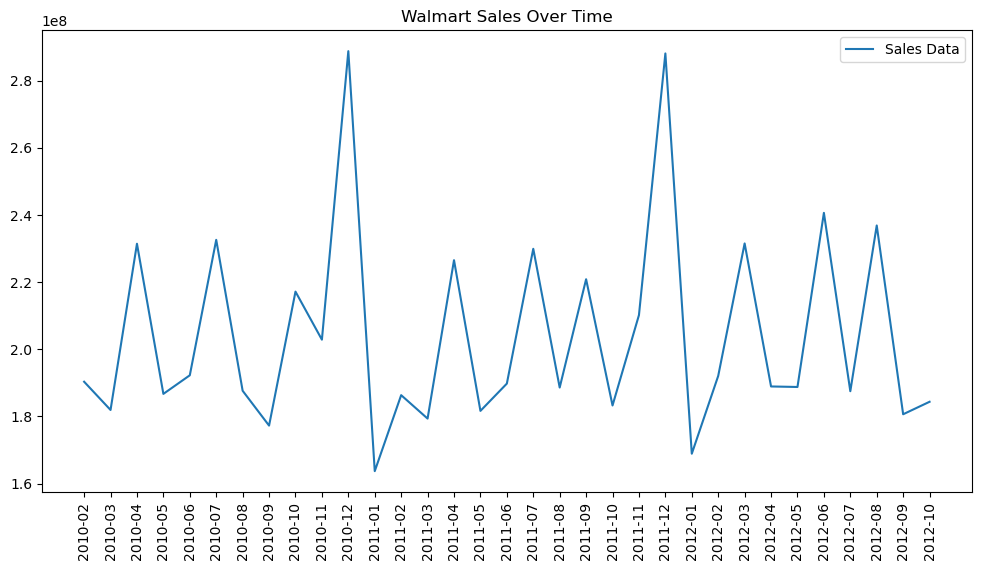

In [34]:
plt.figure(figsize=(12,6))
plt.plot(dfm['Sales'], label='Sales Data')
plt.xticks(rotation=90)
plt.title("Walmart Sales Over Time")
plt.legend()
plt.show()


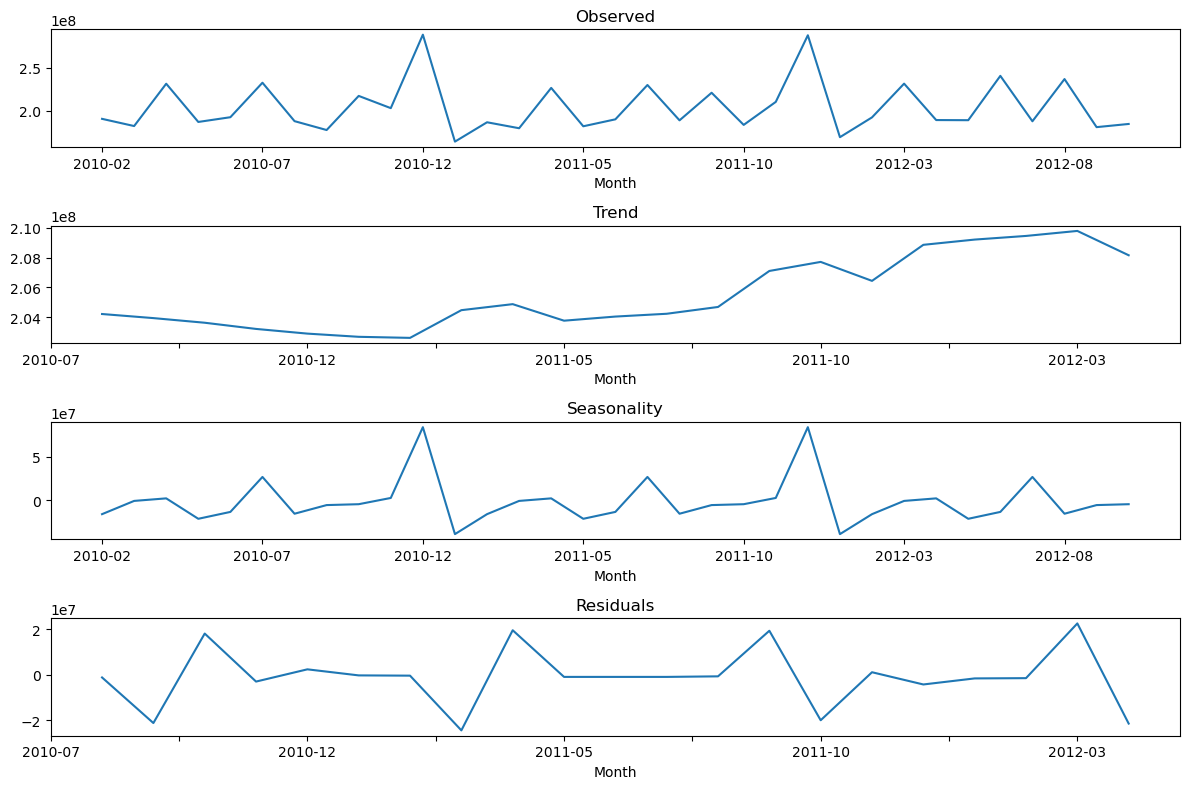

In [35]:
import statsmodels.api as sm

fig, ax = plt.subplots(4, 1, figsize=(12, 8)) 

decomposition = sm.tsa.seasonal_decompose(dfm['Sales'], period=12, model='additive')

decomposition.observed.plot(ax=ax[0], title="Observed")
decomposition.trend.plot(ax=ax[1], title="Trend")
decomposition.seasonal.plot(ax=ax[2], title="Seasonality")
decomposition.resid.plot(ax=ax[3], title="Residuals")

plt.tight_layout() 
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


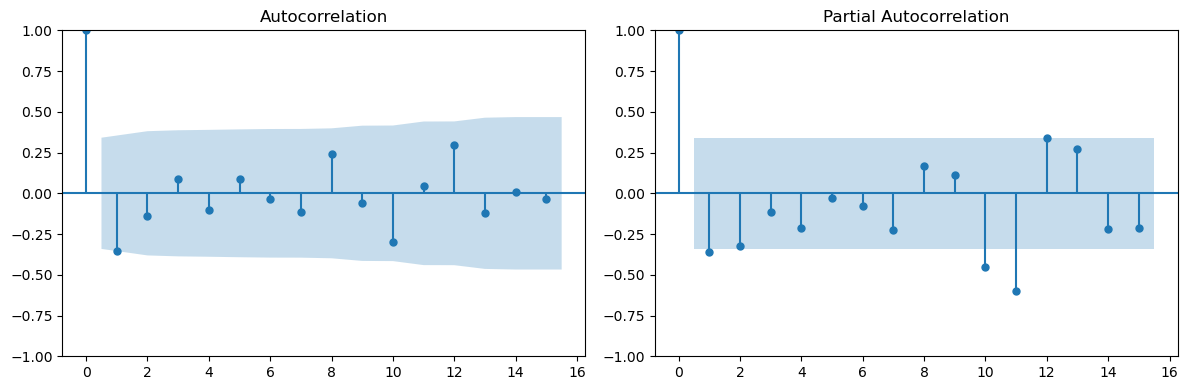

In [36]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

max_lags = min(len(dfm['Sales']) // 2 - 1, 40) #ensures lags do not exceed 50% of the datapoints 

fig, ax = plt.subplots(1, 2, figsize=(12, 4)) 

plot_acf(dfm['Sales'], lags=max_lags, ax=ax[0])  # ACF on first subplot
plot_pacf(dfm['Sales'], lags=max_lags, ax=ax[1])  # PACF on second subplot

plt.tight_layout()  
plt.show()


The ACF plot helps identify q (MA component), and the PACF plot helps identify p (AR component).

## Insights:

1. The Data Shows Strong Seasonality:

The seasonality component in the decomposition plot exhibits clear, repeating patterns every 12 months.
This suggests that sales peak and drop at predictable intervals, likely influenced by annual shopping trends such as holiday seasons, festivals, or promotions.

2. A Gradual Upward Trend in Sales:

The trend component indicates an overall increase in sales over time, suggesting growth in business performance.
There are some periods of decline, possibly due to external factors like economic downturns, inventory issues, or changing consumer demand.

3. ACF & PACF:

The ACF and PACF plots show strong spikes at lag = 12, confirming seasonality with a 12-month cycle.

- Identifying p (AR order) from PACF: The PACF plot shows a significant spike at lag 1, followed by a drop, meaning p = 1.
- Identifying q (MA order) from ACF: The ACF plot also shows a significant spike at lag 1, followed by a decay, meaning q = 1.

4. Possible External Influences on Sales:

Large spikes in the observed sales data indicate that there are certain months with significantly higher sales, likely due to external factors like Black Friday, holiday sales, or new product launches.

## Augmented Dickey-Fuller (ADF) test

We use the Augmented Dickey-Fuller (ADF) test to check if the data is stationary. A p-value < 0.05 confirms stationarity.

In [19]:
# Testing for stationary
from statsmodels.tsa.stattools import adfuller

#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    
    for value,label in zip(result,labels):
        print(f"{label} : {value}")
        
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
        
adfuller_test(dfm['Sales'])

ADF Test Statistic : -6.164473786749468
p-value : 7.044293727364498e-08
#Lags Used : 1
Number of Observations Used : 31
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


Since data is Stationary, we do not necessarily need to perform Differencing.

## Auto ARIMA

Automatically finds the best (p,d,q) based on AIC & other metrics.

In [121]:
pip install pmdarima

Defaulting to user installation because normal site-packages is not writeable
     ------------------------------------ 615.0/615.0 kB 530.0 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [149]:
from pmdarima import auto_arima

auto_arima_model = auto_arima(dfm['Sales'], seasonal=False, stepwise=True, trace=True)

print(auto_arima_model.summary())

forecast = auto_arima_model.predict(n_periods=12)


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1248.153, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1359.226, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1269.760, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1342.175, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1242.823, Time=0.12 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1339.784, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1245.617, Time=0.13 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=1242.567, Time=0.20 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=1338.736, Time=0.06 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=1243.432, Time=0.33 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=1341.230, Time=0.08 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=1245.173, Time=0.24 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.45 sec

Best model:  ARIMA(1,0,3)(0,0,0)[0]       

In [158]:
print(dfm.index.min(), dfm.index.max())  
print(dfm.shape) 


2010-02 2012-10
(33, 3)


## Building the ARIMA Model

In [148]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(dfm['Sales'], order=(1, 0, 3))  
model_fit = model.fit()


## Tuning the model 

We initially had two options to choose from:
- (1,0,1) w.r.t ACF, PACF and ADF Test
- (0,1,1) w.r.t AIC
- (1, 0, 3) w.r.t. auto Arima

Upon careful evaluation how well these configurations predict future data, (1, 0, 3), worked comparatively better wtih RMSE and MAPE as the deciding factor.


## Forecasting Existing Data using ARIMA

<AxesSubplot:xlabel='Month'>

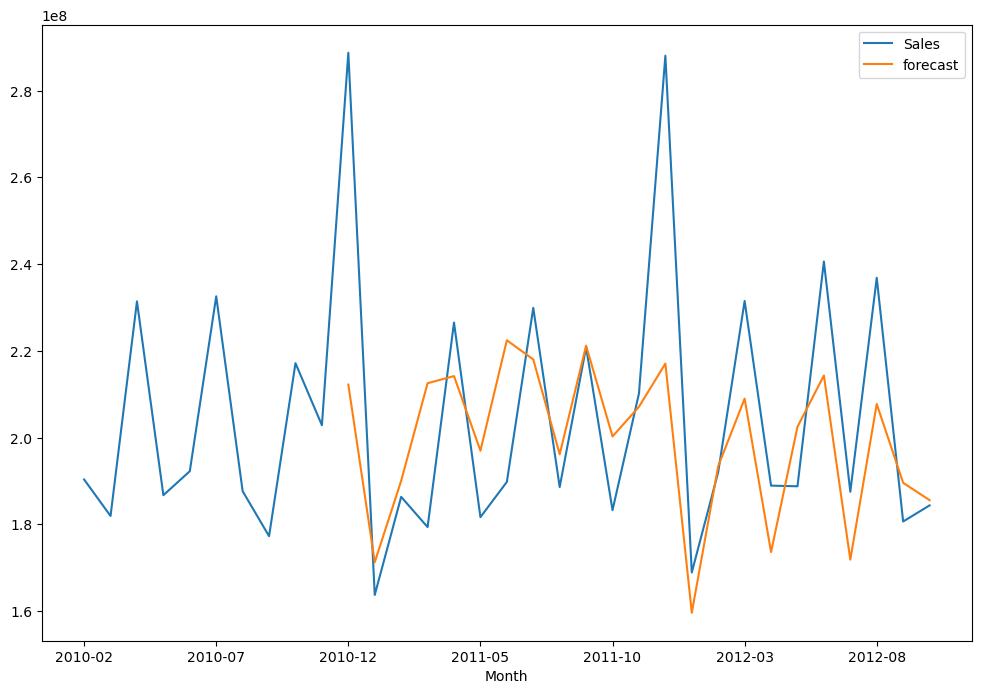

In [146]:
dfm['forecast'] = model_fit.predict(start=10, end=32, dynamic=False)
dfm[['Sales', 'forecast']].plot(figsize=(12, 8))


## ARIMA Model Evaluation using RMSE and MAPE

In [147]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

actual = dfm['Sales'][10:32]
predicted = dfm['forecast'][10:32]

rmse = np.sqrt(mean_squared_error(actual, predicted))
mape = mean_absolute_percentage_error(actual, predicted)

print("ARIMA: ")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape * 100:.2f}%")

ARIMA: 
RMSE: 27722095.41677694
MAPE: 8.88%


## Building the SARIMA Model

In [115]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(dfm['Sales'], order=(2, 0, 2), seasonal_order=(2, 0, 1, 12))
model_fit = model.fit()

## Forecasting Existing Data using SARIMA

<AxesSubplot:xlabel='Month'>

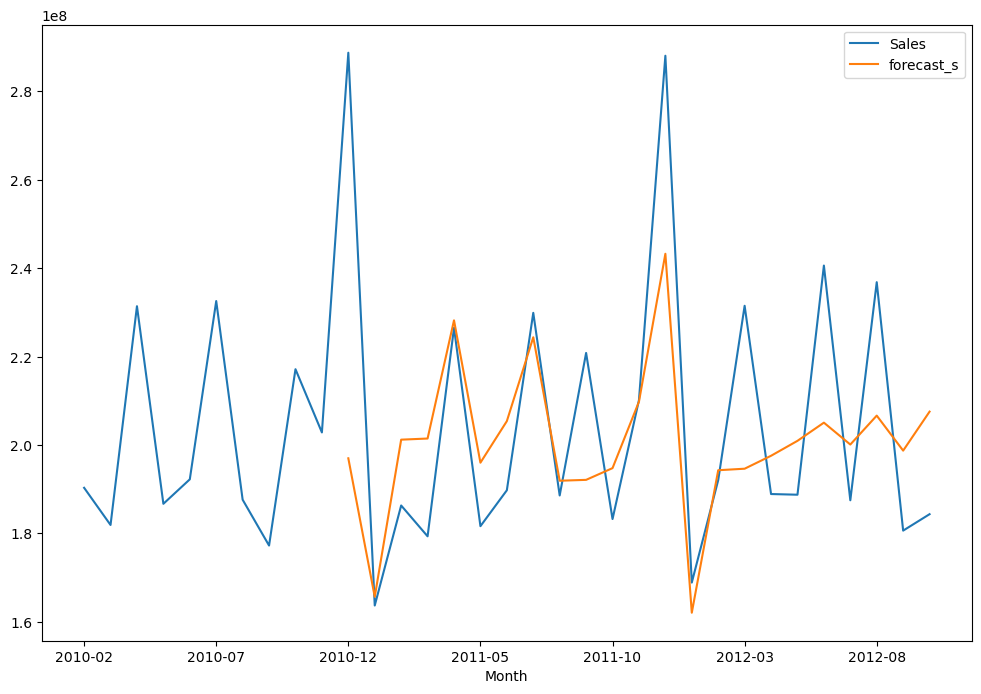

In [116]:
dfm['forecast_s'] = model_fit.predict(start=10, end=32)
dfm[['Sales', 'forecast_s']].plot(figsize=(12, 8))


In [58]:
dfm

,Sales,forecast,forecast_s
Month,,,
2010-02,1.903330e+08,NaN,NaN
2010-03,1.819198e+08,NaN,NaN
2010-04,2.314124e+08,NaN,NaN
2010-05,1.867109e+08,NaN,NaN
2010-06,1.922462e+08,NaN,NaN
2010-07,2.325801e+08,NaN,NaN
2010-08,1.876401e+08,NaN,NaN
2010-09,1.772679e+08,NaN,NaN
2010-10,2.171618e+08,NaN,NaN


## SARIMA Model Evaluation using RMSE and MAPE

In [150]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

actual = dfm['Sales'][10:32]
predicted = dfm['forecast_s'][10:32]

rmse = np.sqrt(mean_squared_error(actual, predicted))
mape = mean_absolute_percentage_error(actual, predicted)

print("SARIMA: ")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape * 100:.2f}%")


SARIMA: 
RMSE: 27707153.183749087
MAPE: 8.45%


## Forecasting future sales using SARIMA Model

As our trained SARIMA model performs comparatively better, we will now use it to forecast the next 12 months of sales.

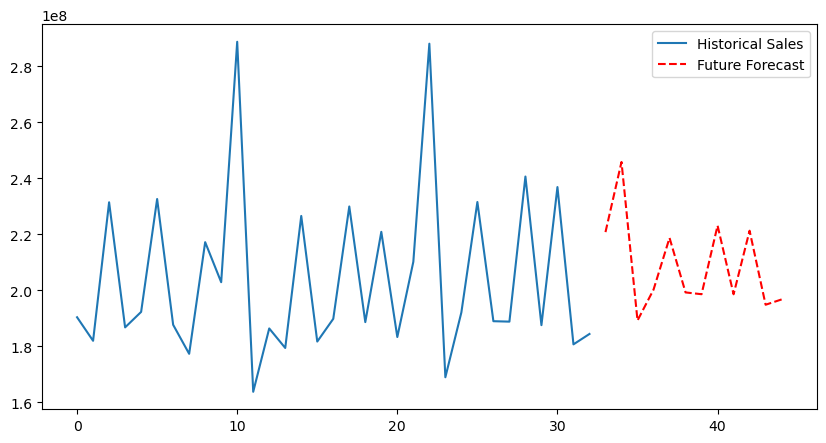

In [119]:
future_steps = 12  # Forecasting 12 months ahead
future_forecast = model_fit.forecast(steps=future_steps) #using the SARIMA model

plt.figure(figsize=(10,5))
plt.plot(range(len(dfm['Sales'])), dfm['Sales'], label="Historical Sales")
plt.plot(range(len(dfm['Sales']), len(dfm['Sales']) + future_steps), future_forecast, label="Future Forecast", linestyle="dashed", color="red")
plt.legend()
plt.show()
